<a href="https://colab.research.google.com/github/OculusMode/ILL/blob/main/ILL_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from copy import deepcopy
from itertools import combinations, permutations
from fractions import Fraction
import sympy as sy
from collections import defaultdict, deque
import math
import matplotlib.pyplot as plt
# used to import groups from sagemath files
from ast import literal_eval as make_tuple
# used for optimization problem 'lifting' in paper
from scipy.optimize import nnls 
# used to save partitions in file so we don't need to create them each time
import pickle
# will be used to not to run out of RAM(in meet and join)
import gc
# for graphs
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class Partition:
    
    @staticmethod
    def to_partn(parn):
        return frozenset([frozenset(i) for i in parn])

    def __init__(self, partn, tags):
        self.partn = self.to_partn(rule)
        self.tags = tags
    
    def __eq__(self, other):
        return self.partn == other.partn
    
    def __hash__(self):
        return hash(self.partn)
    
    def is_coarser(self, other_rule):
        rule_1 = self.partn
        rule_2 = other_rule.partn
        """Returns 1 if coarse, -1 if finer, 0 if undecidable"""
        l_1 = len(rule_1)
        l_2 = len(rule_2)
        # if both lengths are same then they cannot be finer/coarser
        if l_1 == l_2:
            return 0
        # the rule with smaller rule_domain MAY BE coarser
        if l_1 > l_2:
            for i in rule_1:
                for j in rule_2:
                    if not (set(i).issubset(set(j)) or set(i).isdisjoint(set(j))):
                        return 0
            return -1
        else:
            for i in rule_2:
                for j in rule_1:
                    if not (set(i).issubset(set(j)) or set(i).isdisjoint(set(j))):
                        return 0
            return 1

    @staticmethod
    def join(rule_1, rule_2):
        new_rule = []
        rule_2 = [set(i) for i in rule_2]
        for i in rule_1:
              for j in rule_2:
                intersection = i.intersection(j)
                if intersection:
                    new_rule.append(frozenset(intersection))
                    j.difference_update(intersection)
        r = Partition.to_partn(new_rule)
        del new_rule
        gc.collect()
        return r

    @staticmethod
    def meet(rule_1, rule_2):
      new_rule = [set(i) for i in rule_1]
      for i in rule_2:
        idxs_to_remove = []
        temp_set = set(i)
        for jindex, j in enumerate(new_rule):
          if temp_set.intersection(j):
            temp_set.update(j) # taking Union and storing in temp_set
            idxs_to_remove.append(jindex)
        # now we can remove indexes
        # here we are using reversed so we don't mess up by removing smaller indexes first
        for i in reversed(idxs_to_remove):
          new_rule.pop(i)
        new_rule.append(temp_set)
      r = Partition.to_parn(new_rule)
      del new_rule
      gc.collect()
      return r

print(
    Partition.join(
        frozenset({frozenset({4, 5}), frozenset({2}), frozenset({1}), frozenset({3})}),
        frozenset({frozenset({1, 2, 3, 4}), frozenset({5})})
    )
)

frozenset({frozenset({2}), frozenset({3}), frozenset({1}), frozenset({5}), frozenset({4})})


In [4]:
"""
This function is just to demonstrate how partitions can increase following bellman number(after than exponential)
"""
def get_all_partitions(collection):
  if len(collection) == 1:
    # coarsest
    yield [collection]
    return
  first = collection[0]
  for other in get_all_partitions(collection[1:]):
    for n, i in enumerate(other):
      yield other[:n] + [[ first ] + i]  + other[n+1:]
    yield [ [ first ] ] + other
# all_partitions = set()
# for n, p in enumerate(get_all_partitions([1,2,3,4]), 1):
#     # print(n, sorted(p))
#     all_partitions.add(
#         Partition(p, [n])
#     )

In [ ]:
"""
This function will represent how partition looks, note that it has no values yet, they are just partitions
"""
def represent_partition(partition, dimension_size=20, show_num=False):
  matrix = np.arange(dimension_size*dimension_size).reshape(dimension_size, dimension_size)
  z = 0
  for i in partition:
    for j in i:
      row = j//dimension_size
      col = j%dimension_size
      matrix[row][col] = z
    z+=1
  fig, ax = plt.subplots()
  ax.matshow(matrix, cmap=plt.cm.Blues)
  if show_num:
    for i in range(dimension_size):
      for j in range(dimension_size):
          c = matrix[j,i]
          ax.text(i, j, str(c), va='center', ha='center')
  plt.show()

"""
Converting cyclic notations given by sage math to out partition
"""
def cyclic_notation_to_partition(notation, dimension):
  notation = notation.replace(')(', '),(')
  partition = make_tuple(f'[{notation}]')
  checked = set()
  for i in partition:
    for j in i:
      checked.add(j)
  left_out = set(range(1, 401)) - checked
  partitions = set([frozenset([j-1 for j in i]) for i in partition])
  for i in left_out:
    partitions.add(frozenset([i-1]))
  return frozenset(partitions)


In [5]:
""" 
FEATURE GENERATION
We consider the input data space to be the n-dimensional Euclidean space: X = Rn, 
so every data point x ∈ X is an n-dimensional vector, 
a standard setting in machine learning.

To systematically generate a large and expressive pool of candidate features, 
we start with two types of basis features on X, 
namely (selection) windows and (basis) descriptors, 
and then use them to span a feature pool via function composition.
"""
class Window:
    def __init__(self, method, name):
        self.method = method
        self.name = name

def get_all_possible_selections(N):
    """
    This function will be used in finding all possible slices of Nd array
    i.e. if array is 2d, we can have [0], [1], [0,1]
    """
    a = list(range(N))
    for i in range(1, N+1):
        for j in combinations(a, r=i):
            yield Window(method=lambda A: A[list(j)], name=j)
            
# Order function defined in paper
def order(Z):
    l = np.argsort(Z,  axis=None)
    p = ''
    for i in range(len(l)-1):
        p+=str(l[i])
        if Z[l[i]] == Z[l[i+1]]:
            p+='='
        else:
            p+='<'
      # for last index
    if len(l)>1:
        p+=str(l[i+1])
    return p


class BasisDesctiptor:
    def __init__(self, method, name, compatible_methods):
        self.method = method
        self.name = name
        self.compatible_methods = compatible_methods

def sort(arg):
  Z, dimension = arg
  if len(dimension) == 2:
    shape = np.shape(Z)
    return [np.sort(Z, axis = None).reshape(shape), arg[1]]
  if dimension[0] == 1:
    # print(np.sort(Z, axis=0))
    return [np.sort(Z, axis = 0), arg[1]]
  return [np.sort(Z, axis=1), arg[1]]

B = {
  BasisDesctiptor(method = lambda Z: [Z[0]%2, Z[1]], name = 'mod2', compatible_methods = ['mod3', 'mod4', 'mod5', 'mod6', 'mod7', 'mod8', 'mod9', 'mod10', 'mod11', 'diff', 'order', 'sort']),
  BasisDesctiptor(method = lambda Z: [Z[0]%3, Z[1]], name = 'mod3', compatible_methods = ['mod2', 'mod4', 'mod5', 'mod6', 'mod7', 'mod8', 'mod9', 'mod10', 'mod11', 'diff', 'order', 'sort']),
  # BasisDesctiptor(method = lambda Z: [Z[0]%4, Z[1]], name = 'mod4', compatible_methods = ['mod3', 'mod2', 'mod5', 'mod6', 'mod7', 'mod8', 'mod9', 'mod10', 'mod11', 'diff', 'order', 'sort']),
  # BasisDesctiptor(method = lambda Z: [Z[0]%5, Z[1]], name = 'mod5', compatible_methods = ['mod3', 'mod4', 'mod2', 'mod6', 'mod7', 'mod8', 'mod9', 'mod10', 'mod11', 'diff', 'order', 'sort']),
  # BasisDesctiptor(method = lambda Z: [Z[0]%6, Z[1]], name = 'mod6', compatible_methods = ['mod3', 'mod4', 'mod5', 'mod2', 'mod7', 'mod8', 'mod9', 'mod10', 'mod11', 'diff', 'order', 'sort']),
  # BasisDesctiptor(method = lambda Z: [Z[0]%7, Z[1]], name = 'mod7', compatible_methods = ['mod3', 'mod4', 'mod5', 'mod6', 'mod2', 'mod8', 'mod9', 'mod10', 'mod11', 'diff', 'order', 'sort']),
  # BasisDesctiptor(method = lambda Z: [Z[0]%8, Z[1]], name = 'mod8', compatible_methods = ['mod3', 'mod4', 'mod5', 'mod6', 'mod7', 'mod2', 'mod9', 'mod10', 'mod11', 'diff', 'order', 'sort']),
  # BasisDesctiptor(method = lambda Z: [Z[0]%9, Z[1]], name = 'mod9', compatible_methods = ['mod3', 'mod4', 'mod5', 'mod6', 'mod7', 'mod8', 'mod2', 'mod10', 'mod11', 'diff', 'order', 'sort']),
  BasisDesctiptor(method = lambda Z: [Z[0]%10, Z[1]], name = 'mod10', compatible_methods = ['mod3', 'mod4', 'mod5', 'mod6', 'mod7', 'mod8', 'mod9', 'mod2', 'mod11', 'diff', 'order', 'sort']),
  BasisDesctiptor(method = lambda Z: [Z[0]%11, Z[1]], name = 'mod11', compatible_methods = ['mod3', 'mod4', 'mod5', 'mod6', 'mod7', 'mod8', 'mod9', 'mod10', 'mod2', 'diff', 'order', 'sort']),
  BasisDesctiptor(method = lambda arg: sort(arg), name = 'sort', compatible_methods = ['mod2', 'mod3', 'mod4', 'mod5', 'mod6', 'mod7', 'mod8', 'mod9', 'mod10', 'mod11', 'diff', 'order', 'mod12']),
  # BasisDesctiptor(method = order, name = 'order', compatible_methods = []),
  # BasisDesctiptor(method = lambda Z: np.diff(Z), name = 'diff', compatible_methods = ['diff', 'order', 'sort', 'diff'])
} 

def is_possible_composition(C):
    """
    helper method to see if our composition is valid or not
    """
    for i in range(len(C)-1):
        if C[i+1].name not in C[i].compatible_methods:
            return False
        return True

def D(k, B):
    """
    basically Dk is composition of functions of B with length k
    so one element of D3 can be mod12 o diff o sort
    """
    for i in range(1, k+1):
        for j in permutations (B, r=i):
            if is_possible_composition(j):
                yield j

def compose(functions):
    """ Helper function to compose functions """
    def inner(arg):
        for f in reversed(functions):
              arg = f(arg)
        return arg
    return inner

class CompositionOperator:
    def __init__(self, name, method, window_method):
        self.method = method
        self.name = name
        self.window_method = window_method

def phi(k, B, selection_method, N):
    """
    phi is collectio of Dk and selection method
    """
    for _D in D(k, B):
        name = [i.name for i in _D]
        methods = [i.method for i in _D]
        for window_fn in selection_method(N):
            new_name = deepcopy(name)
            new_name.append(window_fn.name)
            method = compose(methods)
            composition_operator = CompositionOperator(new_name, method, window_fn.name)
            yield composition_operator

def get_partition_by_feature(operation, dimensions_len, dimension):
  partition = defaultdict(list, {})
  # X = np.arange(dimensions_len*dimensions_len).reshape((dimensions_len, dimensions_len))
  if len(dimension) == 1:
    c = np.arange(dimensions_len)
    X = np.rollaxis(np.tile(c, (dimensions_len, 1)), dimension[0])
    r, _ = operation([X, dimension])
    z = 0
    for i in r:
      for j in i:
        partition[j].append(z)
        z+=1
    return frozenset([frozenset(i) for i in partition.values()])
  else:
    X = np.arange(dimensions_len*dimensions_len).reshape((dimensions_len, dimensions_len))
    r,_ = operation([X, dimension])
    z = 0
    for i in r:
      for j in i:
        partition[j].append(z)
        z+=1
    return frozenset([frozenset(i) for i in partition.values()])

In [ ]:
% cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
all_partitions = set()
for i in phi(2, B, get_all_possible_selections, 2):
    names = deepcopy(i.name)
    names.append(i.window_method)
    partition = Partition(get_partition_by_feature(i.method, 20, i.window_method), tags = names)
    all_partitions.add(partition)
# IMPORT THE PARTTIONS FROM SAGEMATH FILE
# with open('./thesis_files/cyc400.txt', 'r') as fp:
#     for line in fp.readlines():
#         partition = Partition(cyclic_notation_to_partition(line, 20), tags = ['cyclic_group'])
#         all_partitions.add(partition)
# with open('./thesis_files/dihed400.txt', 'r') as fp:
#     for line in fp.readlines():
#         partition = Partition(cyclic_notation_to_partition(line, 20), tags = ['dihedral_group'])
#         all_partitions.add(partition)

In [ ]:
len(all_partitions)

34

In [ ]:
class PosetNode:
    def __init__(self, value, parents, children):
        self.value = value
        self.children = []
        self.parents = []
class PartitionPoset:
    def __init__(self, total_nodes=None):
        # denotes the set of all P ∈ P with size k
        self.size2partns = defaultdict(list)
        # denotes the set of all tags inducing Partition
        self.partn2tags = defaultdict(list)
        # below is equivalent to po_matrix
        self.part2descendents = defaultdict(set) # descent is FINER
        self.part2ancestors = defaultdict(set) # ancesteror is COARSER
        
        self.part2parents = defaultdict(set)
        self.part2children = defaultdict(set)
        
  
    def add_partition(self, P):
        part_len = len(P.partn)
        parts_of_same_size = self.size2partns[part_len]
        # if same partition comes BUT TAGS are different, then update TAGS
        if P in parts_of_same_size:
            # update tags of partition
            self.partn2tags[P].extend(P.tags) # TODO MANAGE DUPLICATION
            return
        # update P.size2partns[|Pτ |] by adding Pτ
        self.partn2tags[P] = P.tags
        self.size2partns[part_len].append(P)
        # update P.po matrix and P.hasse diagram
        for i in range(1, part_len):
            parts = self.size2partns[i]
            for part in parts:
                # size of part is less than P so P can be either finer or not coarse (it can definitely not be coarser)
                if part.is_coarser(P) == 1:
                    # if coarse then add entries on both nodes for ancestor and descendent
                    self.part2descendents[part].append(P)
                    self.part2ancestors[P].append(part)
                    # TODO:: FIGURE OUT A WAY IF ITS PARENT OR CHILD
#                     if Partition.meet(P.partn, part.partn) == part.partn:
#                         self.part2parents[P].append(part)
#                         self.part2children[P].append(part)
                tags_1 = P.tags
                tags_2 = part.tags
                join_tags = deepcopy(tags_1)
                join_tags.append('join')
                join_tags.extend(tags_2)
                meet_tags = deepcopy(tags_1)
                meet_tags.append('meet')
                meet_tags.extend(tags_2)
                
                join_part = Partition(Partition.join(P.partn, part.partn), join_tags) # add tags
                meet_part = Partition(Partition.meet(P.partn, part.partn), meet_tags) # add tags
                print(join_part.partn)
                print(meet_part.partn)
                if meet_part != P and meet_part != part:
                    print('bb')
                    self.part2parents[P] = meet_part
                    self.part2parents[part] = meet_part
                    # if partition is already inside our poset, then (DO NOTHING FOR NOW)
                    if meet_part not in self.partn2tags:
                      # print('inside')
                      self.add_partition(meet_part)
                    # self.add_partition(join_part)
                if join_part != P and join_part != part:
                    print('aaa')
                    self.part2children[P] = join_part
                    self.part2children[part] = join_part
                    # self.add_partition(meet_part)
                    if join_part not in self.partn2tags:
                      # print('_inside')
                      self.add_partition(meet_part)

    def add_partitions(self, partitions):
      q = deque(partitions)
      iii = 0
      # we will make semi lattice of 100 partitions only for now
      while q and iii<100:
        iii+=1
        print(len(q), end=' ')
        # if len(q)>10:
        #   break
        # print('q::', len(q))
        P = q.popleft()
        part_len = len(P.partn)
        parts_of_same_size = self.size2partns[part_len]
        # if same partition comes BUT TAGS are different, then update TAGS
        if P in parts_of_same_size:
            # update tags of partition
            self.partn2tags[P].extend(P.tags) # TODO MANAGE DUPLICATION
            # return
        # update P.size2partns[|Pτ |] by adding Pτ
        self.partn2tags[P] = P.tags
        self.size2partns[part_len].append(P)
        # update P.po matrix and P.hasse diagram
        for i in range(1, part_len+1):
            parts = self.size2partns[i]
            for part in parts:
                # size of part is less than P so P can be either finer or not coarse (it can definitely not be coarser)
                if part.is_coarser(P) == 1:
                    # if coarse then add entries on both nodes for ancestor and descendent
                    self.part2descendents[part].add(P)
                    self.part2ancestors[P].add(part)
                
                tags_1 = P.tags
                tags_2 = part.tags
                join_tags = deepcopy(tags_1)
                join_tags.append('join')
                join_tags.extend(tags_2)
                meet_tags = deepcopy(tags_1)
                meet_tags.append('meet')
                meet_tags.extend(tags_2)
                join_part = Partition(Partition.join(P.partn, part.partn), join_tags) # add tags
                meet_part = Partition(Partition.meet(P.partn, part.partn), meet_tags) # add tags
                # print(join_part.partn, meet_part.partn)
                # print('parts ',  P.partn, part.partn,)
                # print('join',' ',join_part.partn)
                # print('meet ', meet_part.partn)
                if meet_part != P and meet_part != part:
                    self.part2parents[P].add(meet_part)
                    self.part2parents[part].add(meet_part)
                    self.part2children[meet_part].add(P)
                    self.part2children[meet_part].add(part)
                    # if partition is already inside our poset, then (DO NOTHING FOR NOW)
                    if meet_part not in self.partn2tags:
                      # print('inside')
                      # self.add_partition(join_part)
                      self.partn2tags[meet_part] = meet_tags
                      # STOPPING EARLY
                      # if len(q)<100:
                      q.append(meet_part)
                if join_part != P and join_part != part:
                    self.part2children[P].add(join_part)
                    self.part2children[part].add(join_part)
                    self.part2parents[join_part].add(P)
                    self.part2parents[join_part].add(part)
                    # self.add_partition(meet_part)
                    if join_part not in self.partn2tags:
                      # print('_inside')
                      # self.add_partition(meet_part)
                      self.partn2tags[join_part] = join_tags
                      # STOPPING EARLY
                      # if len(q)<100:
                      #   q.append(join_part)
                      q.append(join_part)

poset = PartitionPoset()
# all_partitions = [
#                   Partition([[1,2], [3,4,5]], ['a']),
#                   Partition([[1,2,3], [4,5]], ['c']),
#                   Partition([[1], [2,3],[4,5]], ['b'])
#                   ]
# __partitions = sorted(all_partitions, key = lambda _: len(_.partn))
# print(__partitions)
# poset.add_partitions(__partitions)
# print(poset.partn2tags)

In [ ]:
% cd /content/drive/MyDrive/
with open('./thesis_files/partitions.pickle', 'wb') as handle:
    pickle.dump(poset, handle, protocol=pickle.HIGHEST_PROTOCOL)


/content/drive/MyDrive


In [ ]:
# loading posets to save creation time
# HEavILY DEPENDS ON DIMENTIONS
% cd /content/drive/MyDrive/
# Load data (deserialize)
with open('./thesis_files/partitions.pickle', 'rb') as handle:
    poset = pickle.load(handle)

/content/drive/MyDrive


In [ ]:
poset

In [7]:
def p(rule):
  return tuple(tuple(i) for i in rule)
# for key, val in poset.part2parents.items():
#   print(p(key.partn), '=>', [p(i.partn) for i in val])
# print()
# for key, val in poset.part2children.items():
#   print(p(key.partn), '=>', [p(i.partn) for i in val])
# print()
# for key, val in poset.part2descendents.items():
#   print(p(key.partn), '=>', [p(i.partn) for i in val])
# for i in poset.partn2tags:
#   if not poset.part2parents[i]:
#     print(i.partn)
len(poset.partn2tags)

NameError: ignored

In [ ]:
some_signal = {
    frozenset({1}): 1,
    frozenset({2}): 1,
    frozenset({3}): 1,
    frozenset({4}): 1,
    frozenset({5}): 1,
}

def normalize_signal(signal):
  tot = 0
  for i in signal.values():
    tot += i
  new_signal = deepcopy(signal)
  for i in new_signal:
    # new_signal[i] = Fraction(new_signal[i], tot)
    new_signal[i] = new_signal[i]/tot
  return new_signal

"""
This fn will find entropy of array, we'll pass a bool to decide for rule or set
fn => here we can pass how to manipulate concept
""" 
def find_entropy(arr, is_rule=False, fn=np.sum, base=2):
  if not is_rule:
    return -np.sum([(i*math.log(i))/math.log(base) for i in arr if i!=0])
  return -np.sum([fn(i)*math.log(fn(i))/math.log(base) for i in arr if i!=0])
# find_entropy([1/6, 1/6, 1/6, 1/6, 2/6])
# find_entropy([[0.25, 0.25], [0.25, 0.125, 0.125]], is_rule=True)
def entropy(rule):
  return find_entropy(rule.values())

some_signal = {
    frozenset([1]): 1/3,
    frozenset([2]): 2/3,
    frozenset([3]): 1/5,
}

# so here rule contains both partitions(as keys) and values of associated with each partition
some_rule = {
    frozenset([1,2]): 4/3,
    frozenset([3]): 1/3,
}

def projection(rule):
  coarsest_cell = set()
  cell_val = 0
  for cell, value in rule.items():
    coarsest_cell.update(cell)
    cell_val+=value
  return {
      frozenset(coarsest_cell): cell_val
  }

def project_on_partition(finest_rule, partition):
  rule = {}
  for cell in partition:
    val = 0
    for i in cell:
      val += finest_rule[frozenset({i})]
    rule[cell] = val
  return rule

def lifting(rules, dimensions=400):
  # print(rules)
  # if there is only one rule we are supposed to lift, we will just divide values for each cell member
  if len(rules) == 1:
    rule = rules[0]
    new_rule = {}
    for key, value in rule.items():
      c_len = len(key)
      val = value/c_len
      for i in key:
        new_rule[frozenset([i])] = val
    return new_rule
  # the part where if there are more than one rules
  else:
    a = []
    b = []
    for rule in rules:
      # print(rule)
      row_index = 0
      rows = len(rule)
      z = np.zeros((rows, dimensions))
      for cell in rule:
        b.append(rule[cell])
        for i in cell:
          z[row_index][i] = 1
        row_index += 1
      a.append(z)
    a.append([np.ones(dimensions)])
    A = np.concatenate((a))
    b.append(1)
    x, _ = nnls(A, b)
    # print(A)
    # print(x, sum(x))
    new_rule = {frozenset([key]): val for key, val in enumerate(x)}
    return new_rule
    
# projection(some_rule)
some_rules = [{
    frozenset([1, 2, 3]): 1/3, #sy.Rational(1, 3),
    frozenset([4, 5]): 1/3, #sy.Rational(1, 3),
    frozenset([0]): 1/3, #sy.Rational(1, 3),
},
{
    frozenset([1, 2]): 1/3, #sy.Rational(1, 3),
    frozenset([3, 4, 5]): 1/3, #sy.Rational(1, 3),
    frozenset([0]): 1/3, #sy.Rational(1, 3),
}]
# project_on_partition(lifting(some_rules), some_rules[1].keys())
print(lifting(some_rules, 6))
# entropy(normalize_signal(some_signal))
# entropy({frozenset({3}): 0, frozenset({2, 4}): 0.5, frozenset({1}): 0.5})

{frozenset({0}): 0.3333333333333332, frozenset({1}): 0.3333333333333333, frozenset({2}): 0.0, frozenset({3}): 0.0, frozenset({4}): 0.3333333333333334, frozenset({5}): 0.0}


In [ ]:
def find_difference(rule_one, rule_two):
  v_one = []
  v_two = []
  for key, val in rule_one.items():
    v_one.append(val)
    v_two.append(rule_two[key])
  return np.linalg.norm(np.array(v_one) - np.array(v_two))
find_difference(some_rules[0], some_rules[0])

def show_signal(rule, original_rule):
  m = np.zeros(400)
  for k, v in rule.items():
    m[list(k)[0]] = v
  ll = m.reshape((20,20))
  fig, (ax1, ax2) = plt.subplots(1,2)
  sns.heatmap(ll, ax=ax1)
  sns.heatmap(original_rule.reshape((20,20)), ax=ax2)
  plt.show()

In [ ]:
def get_coarsest(poset):
  for i in poset.partn2tags:
    if not poset.part2parents[i]:
      return i

# so once we have lattice, We need information lattice(our Partition lattice has no info about Signal)
# hence in a way, we are getting bounded by the domain from here
"""
it's good to note that information lattice and partition lattices are isomorphic
so the only thing we need to do while making information lattice is project signal on every partition(which will be a rule after having information)
"""

# for sake of simplicity we will just assume here that signal is straight plain list(array), so we will use indexes to make things faster
def get_information_rule(partition, signal):
  rule = {}
  for cell in partition:
    rule[cell] = 0
    for i in cell:
      rule[cell] += signal[i]
  return rule

class InformationLattice:
  def __init__(self, poset, signal):
    self.signal = signal
    # denotes the set of all P ∈ P with size k
    self.size2partns = deepcopy(poset.size2partns)
    # denotes the set of all tags inducing Partition
    self.partn2tags = deepcopy(poset.partn2tags)
    # below is equivalent to po_matrix
    self.part2descendents = deepcopy(poset.part2descendents) # descent is FINER
    self.part2ancestors = deepcopy(poset.part2ancestors) # ancesteror is COARSER
    
    self.part2parents = deepcopy(poset.part2parents)
    self.part2children = deepcopy(poset.part2children)
    self.part2rule = {}
    for partn in poset.partn2tags:
      self.part2rule[partn] = get_information_rule(partn.partn, signal)

# so first we're gonna find the rule set which have entropy less than some entropy epsilon
# we will follow BFS like fashion in this
def rules_less_than_epsilon(epsilon, lattice, last_epsilon):
  coarsest_rule = get_coarsest(lattice)
  q = deque([coarsest_rule])
  partitions = set()
  while q:
    P = q.popleft()
    # if lattice.part2rule[P] and entropy(lattice.part2rule[P])<=epsilon:
    entr = entropy(lattice.part2rule[P])<epsilon
    if lattice.part2rule[P] and entropy(lattice.part2rule[P])<epsilon:
      partitions.add(P)
      children = lattice.part2children[P]
      for i in children:
        if i not in partitions:
          q.append(i)
  return partitions

"""
R(k)⇐ := {r ∈ R• | r ⇐ r' for some r' ∈ R(k)}
"""
def Rkarrow(Rdot, Rk, lattice):
  related = set()
  for R in Rdot:
    descendents = lattice.part2descendents[R]
    # since we have some rule which is finer, we will include this in Rk
    # if descendents.union(Rk):
    #   related.add(Rk)
    for _R in Rk:
      if R == _R or R.is_coarser(_R) == 1:
        related.add(R)
        continue
  return related

def RkFeasible(R_less_than_epsilon, Rkarrow):
  return R_less_than_epsilon.difference(Rkarrow)


"""
Equation 6:
"""
def find_best_rule(Rk, RkFeasible, signal, lattice):
  # TODO:: WHAT ABOUT 1st time, Rk?????
  Rkk = [lattice.part2rule[R] for R in Rk]
  lifted = lifting(Rkk)
  s = sum(lifted.values())
  for i in lifted:
    lifted[i] /= s
  diff = 0
  selected_rule = None
  # select maximized
  for R in RkFeasible:
    rule = lattice.part2rule[R]
    projected = project_on_partition(lifted, partition = rule.keys())
    difference = find_difference(rule, projected)
    if diff < difference:
      selected_rule = R
      diff = difference
  return selected_rule, diff

In [ ]:
square_image = np.zeros((20,20))
# square_image[2:10,1] = 1
# square_image[2:10,5] = 1
# square_image[2,1:6] = 1
# square_image[10,1:6] = 1
square_image[2:10, 2:10] = 1
flat_square = square_image.flatten()
flat_square = flat_square/flat_square.sum()
# found actual entropy

original_entropy = find_entropy(flat_square)
# found lattice
info_lattice = InformationLattice(poset, flat_square)
# for i in rules_less_than_epsilon(original_entropy/2, info_lattice):
#   print(info_lattice.part2rule[i])
# R_less_than_epsilon = rules_less_than_epsilon(epsilon, info_lattice)
# RKArrow = Rkarrow(Rdot, Rk, info_lattice)
# RKFeasible = RkFeasible(R_less_than_epsilon, RKArrow)
# print(len(RKArrow))
# [print(i) for i in RKArrow]
# print(RKFeasible)

In [ ]:
original_entropy

6.0

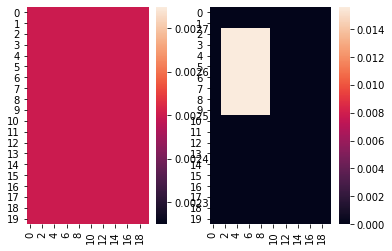

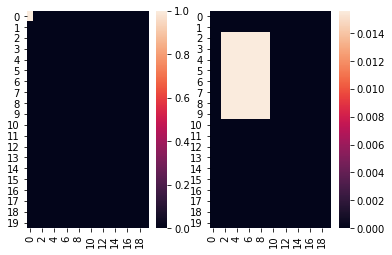

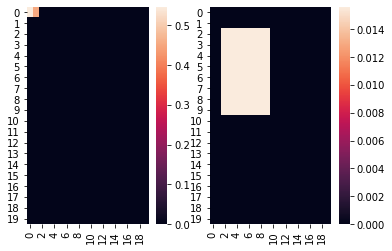

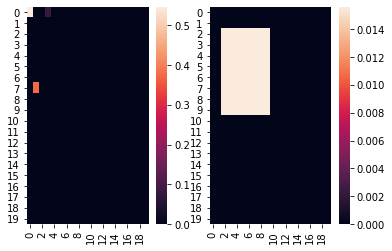

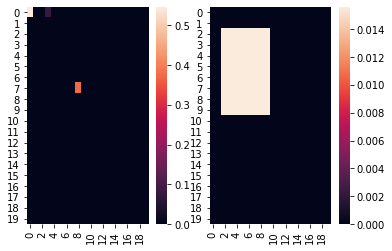

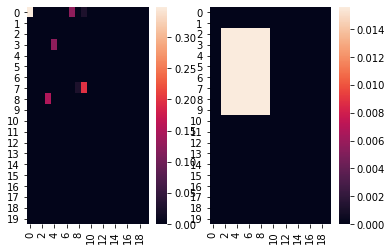

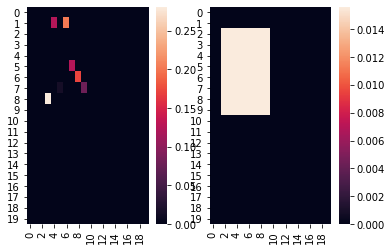

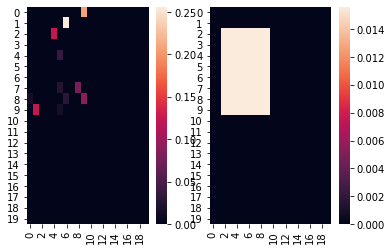

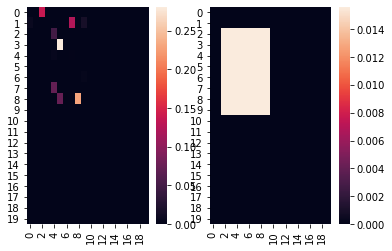

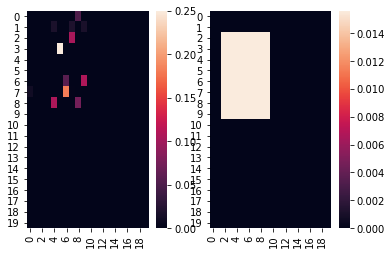

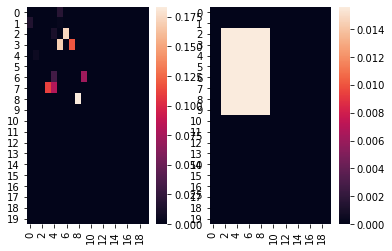

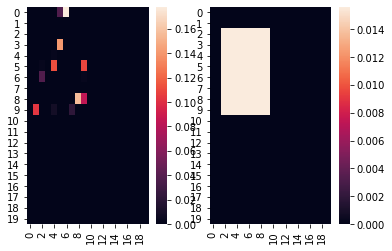

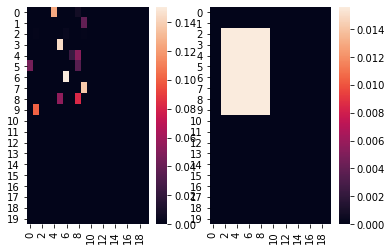

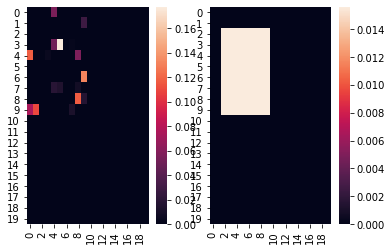

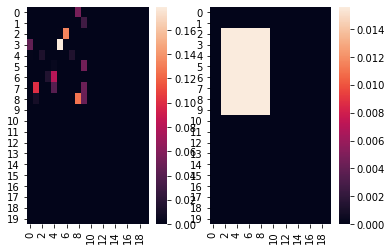

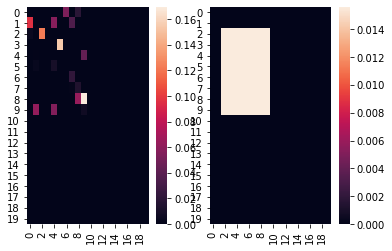

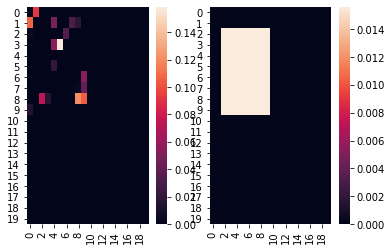

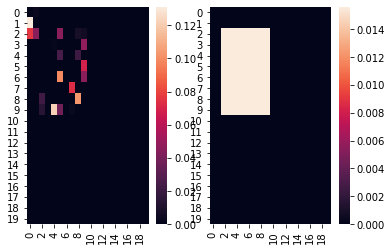

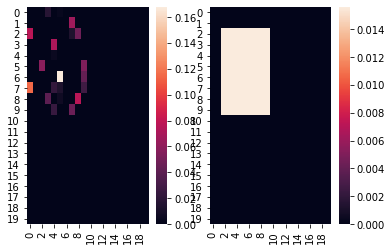

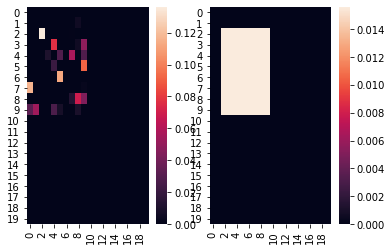

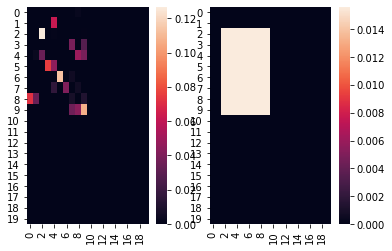

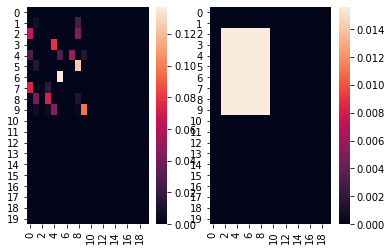

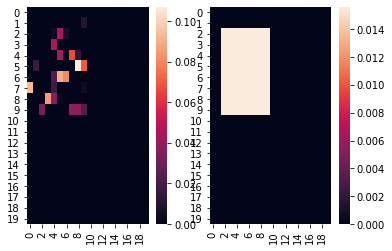

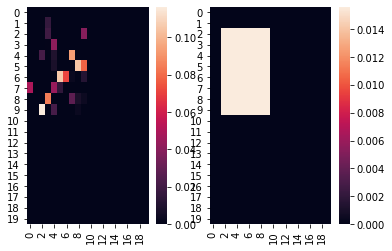

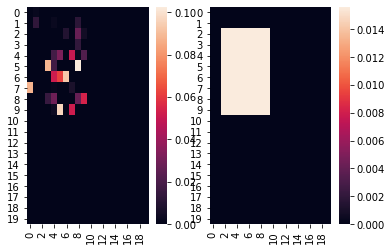

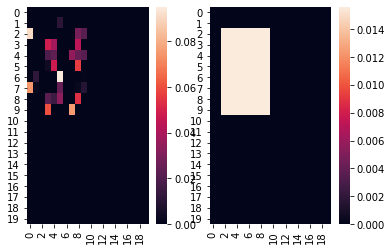

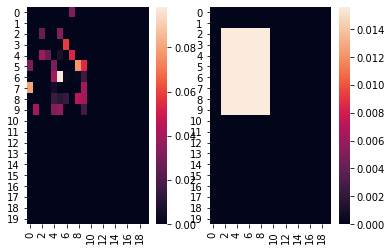

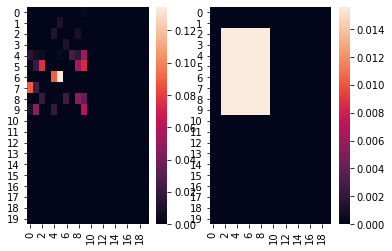

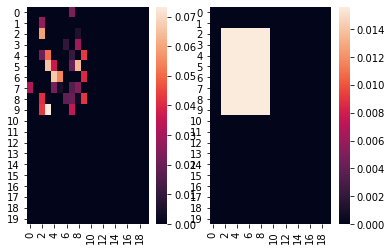

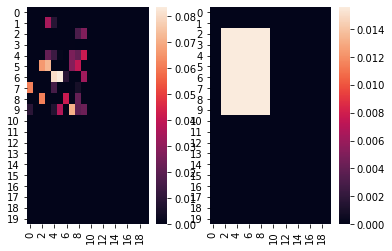

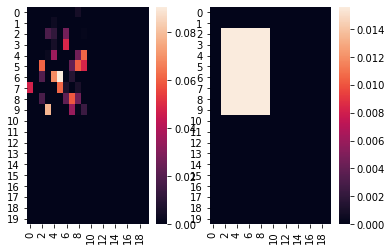

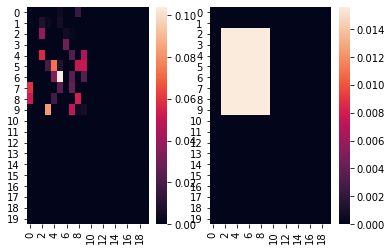

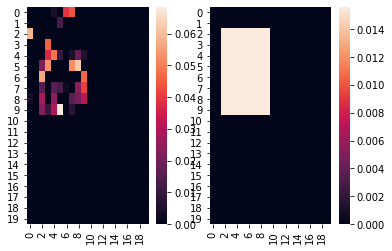

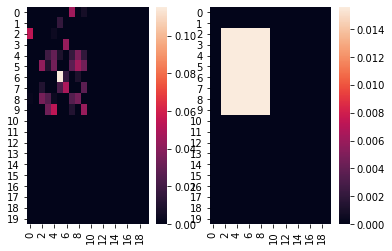

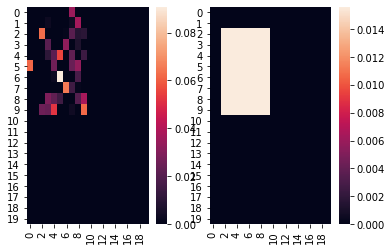

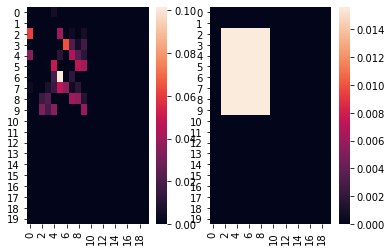

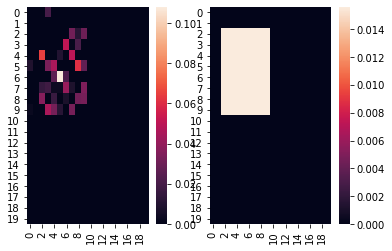

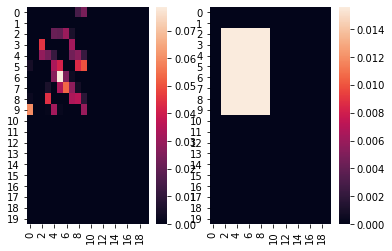

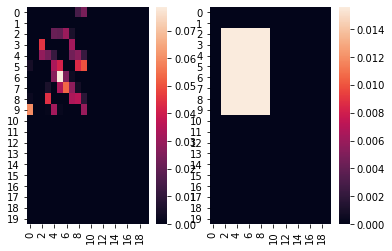

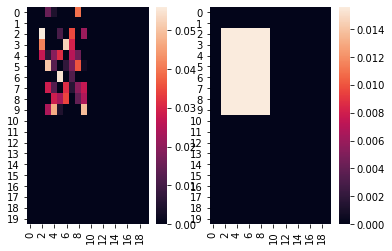

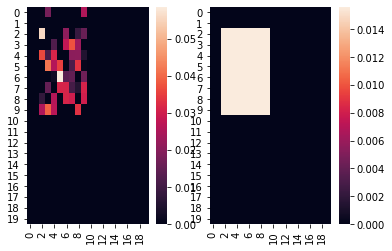

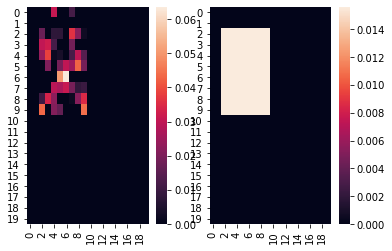

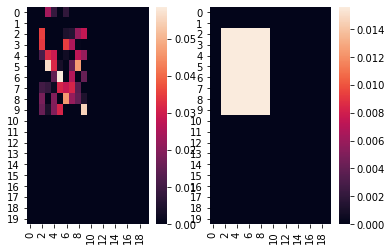

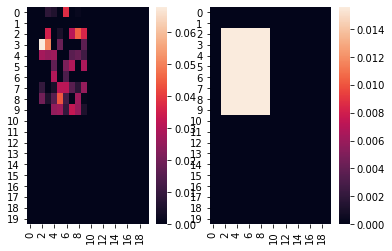

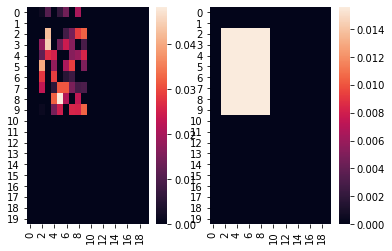

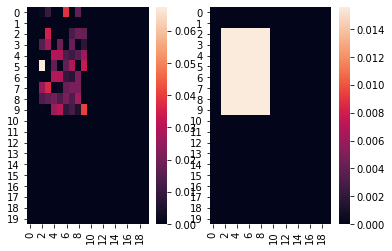

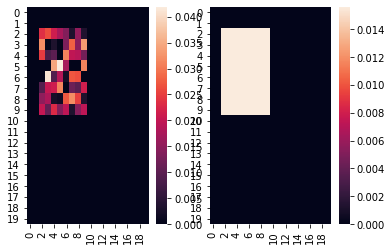

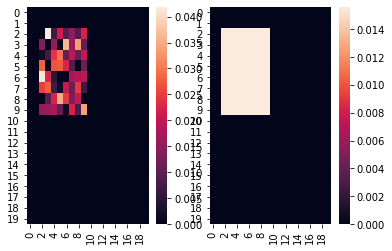

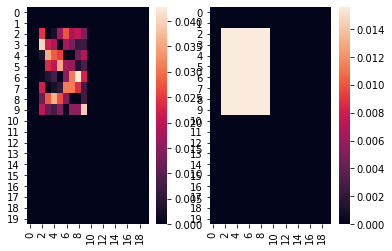

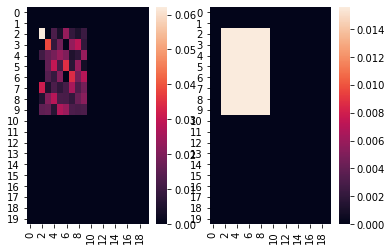

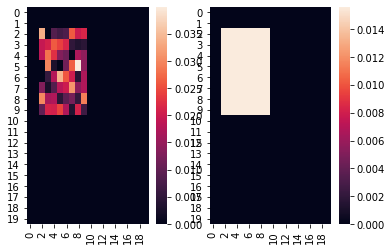

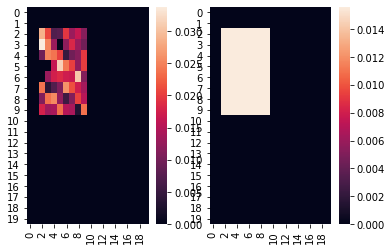

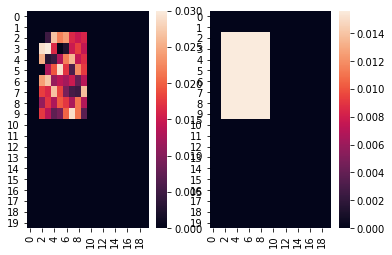

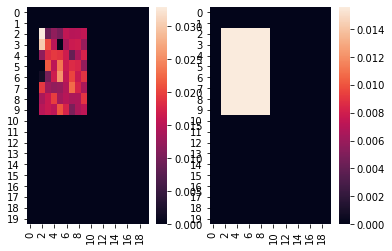

found solN


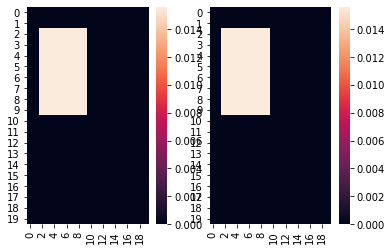

In [ ]:
coarsest = get_coarsest(info_lattice)
last_epsilon = -1
epsilon = 1
Rk = set([coarsest])
Rdot = info_lattice.partn2tags.keys()
threshold = 0.00001
gamma = 0.001

while epsilon<original_entropy:
  R_less_than_epsilon = rules_less_than_epsilon(epsilon, info_lattice, last_epsilon)
  # print(R_less_than_epsilon)
  RKArrow = Rkarrow(Rdot, Rk, info_lattice)
  # print('RKArrow=>', RKArrow)
  RKFeasible = RkFeasible(R_less_than_epsilon, RKArrow)
  # print(RKFeasible)
  old_entr = 0
  found_soln = False
  while RKFeasible:
    r, d = find_best_rule(Rk, RKFeasible, signal=flat_square, lattice=info_lattice)
    if r not in Rk:
      lifted = lifting([info_lattice.part2rule[R] for R in Rk])
      entr = entropy(lifted)
      if abs(original_entropy - entr) <threshold:
        print('found solN')
        found_soln = True
        Rk.add(r)
        show_signal(lifted, flat_square)
        break
      # TODO:: MAKE COMMENT ABOUT WHAT WE DID
      if abs(entr - old_entr) > gamma:
        # represent_partition(info_lattice.part2rule[r].keys())
        old_entr = entr
        Rk.add(r)
        show_signal(lifted, flat_square)
    RKFeasible.difference_update(set([r]))
    # Rk.difference_update(info_lattice.part2descendents[r])
    # represent_partition(info_lattice.part2rule[r].keys())
  if found_soln:
    break
  last_epsilon = epsilon
  epsilon += 1
# for r in Rk:
#   represent_partition(info_lattice.part2rule[r].keys())

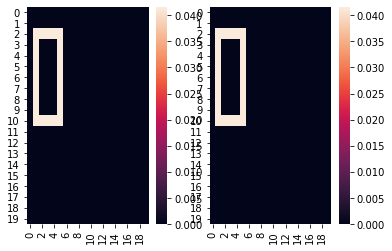

In [ ]:
lll = lifting([info_lattice.part2rule[R] for R in Rk])
show_signal(lll, flat_square)

56


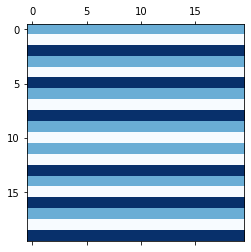

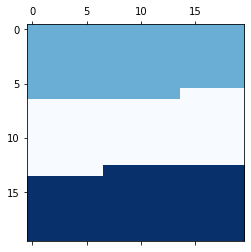

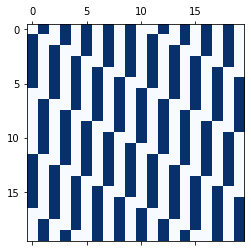

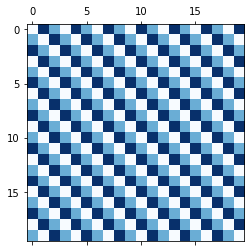

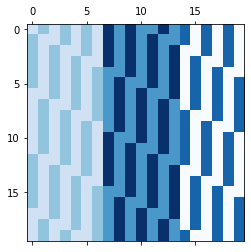

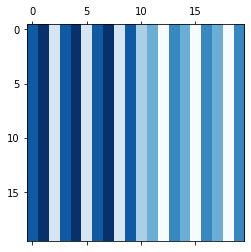

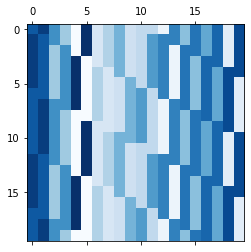

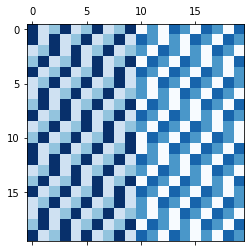

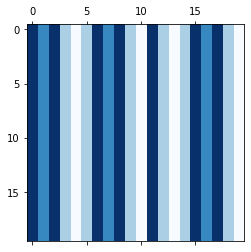

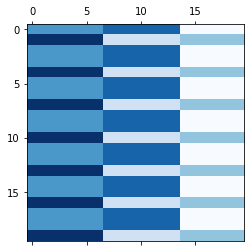

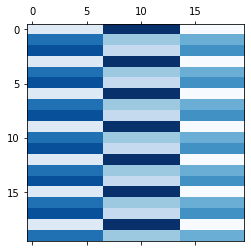

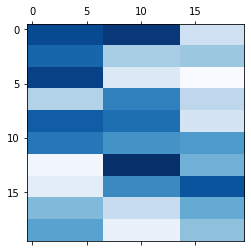

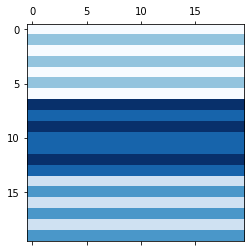

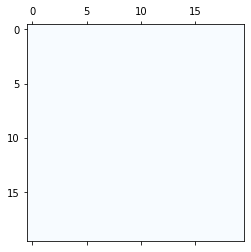

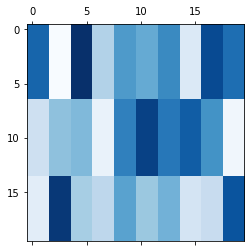

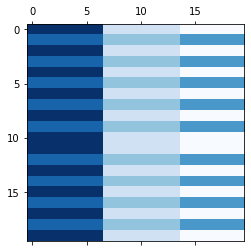

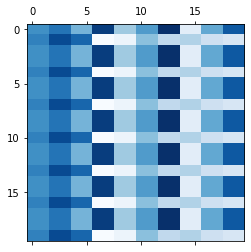

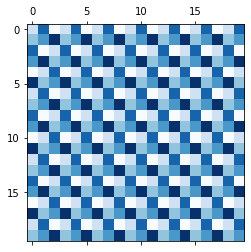

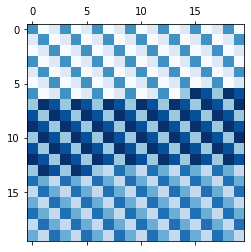

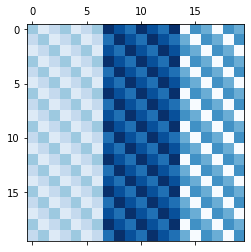

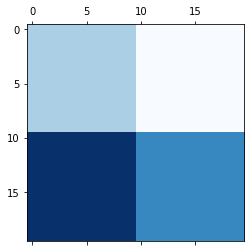

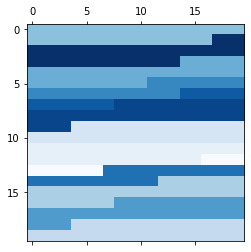

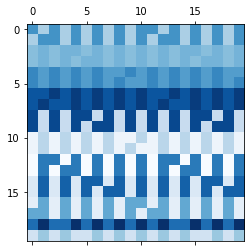

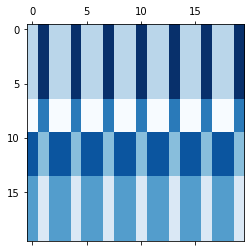

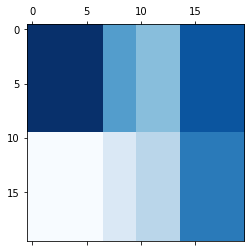

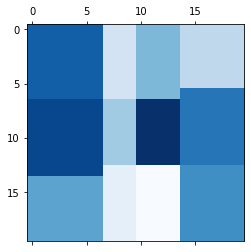

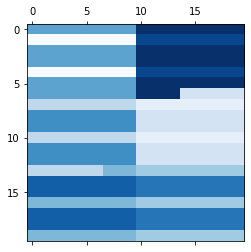

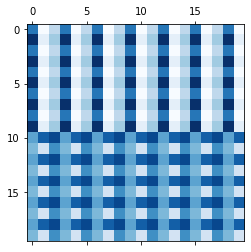

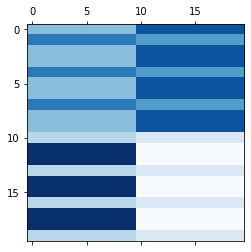

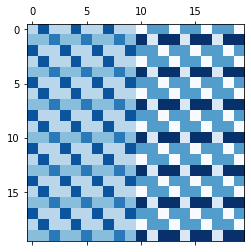

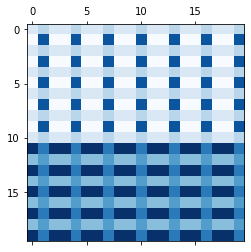

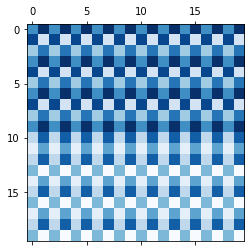

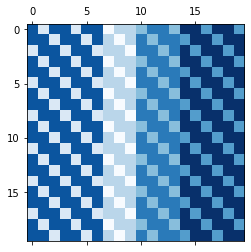

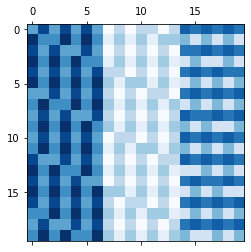

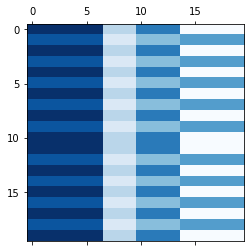

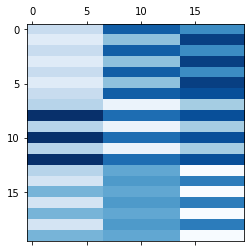

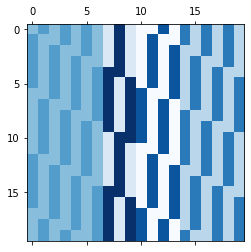

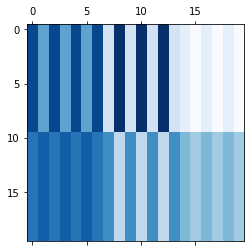

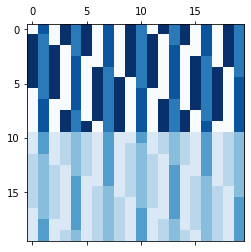

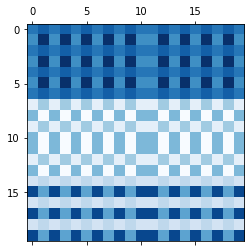

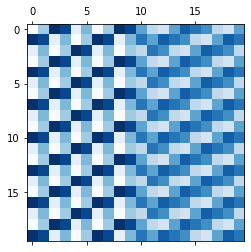

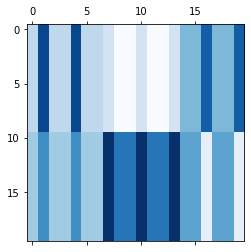

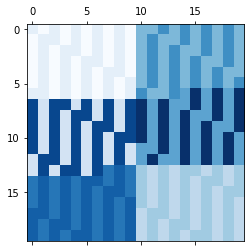

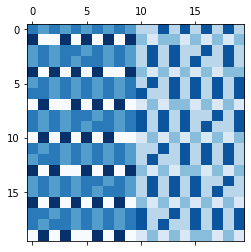

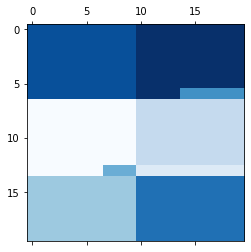

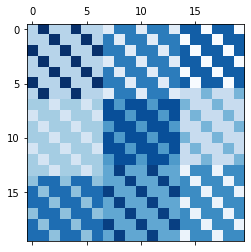

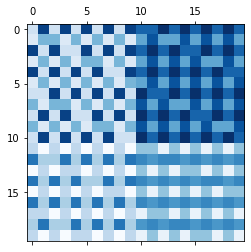

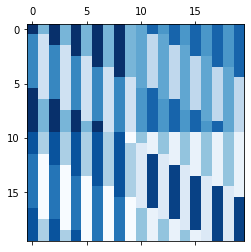

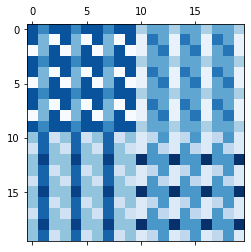

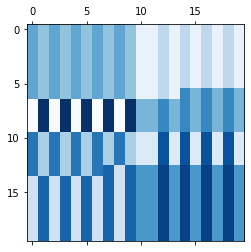

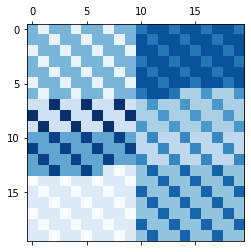

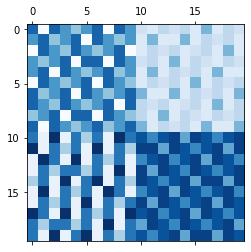

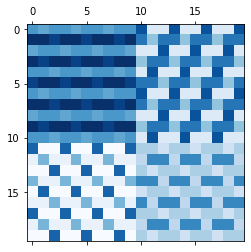

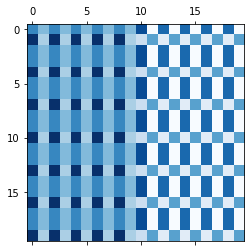

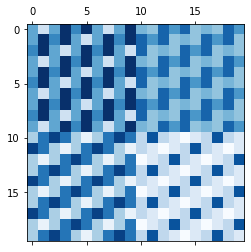

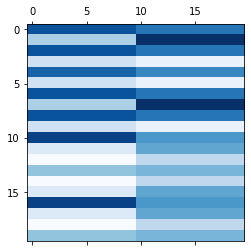

In [ ]:
print(len(Rk))
# for i in sorted(Rk, key=lambda _: len(_.tags)):
#   for idx, j in enumerate(i.tags):
#     if j != 0 and i.tags[idx-1] != j:
#       print(j, end=' ')
#   print()
for i in sorted(Rk, key=lambda _: len(_.tags)):
  represent_partition(info_lattice.part2rule[i].keys())
  # print(i.tags)

In [ ]:
49
mod2 mod3 (0, 1) 
mod3 mod11 (1,) 
sort mod3 (0, 1) 
mod2 mod11 (0, 1) 
mod2 mod11 (0,) 
sort mod3 (0,) 
sort mod2 (0,) 
sort mod11 (0,) 
mod10 mod3 (0,) 
sort mod2 (1,) 
sort mod3 (0,) join mod2 mod11 (0, 1) 
sort mod2 (1,) join mod2 mod3 (1,) 
mod2 mod11 (0, 1) join mod2 mod3 (0, 1) 
mod3 mod11 (0, 1) join mod2 mod11 (1,) 
sort mod2 (0,) join mod2 sort (1,) 
mod3 mod11 (0, 1) join sort mod3 (0,) 
sort mod11 (1,) join mod2 sort (0,) 
sort mod3 (0,) join mod10 mod3 (1,) 
sort mod3 (0,) join sort mod2 (1,) 
mod2 mod11 (0, 1) meet mod2 mod3 (0, 1) 
sort mod3 (1,) join mod2 mod11 (1,) 
mod2 sort (1,) join mod2 mod11 (0, 1) 
sort mod11 (0,) join mod2 mod11 (1,) 
mod10 mod3 (0, 1) join sort mod3 (0,) 
mod2 mod3 (1,) join mod2 mod11 (0,) 
sort mod2 (0,) join mod2 sort (1,) join mod2 mod3 (0,) 
sort mod2 (1,) join mod2 mod3 (0,) join sort mod3 (1,) 
mod2 mod11 (0,) join mod2 mod3 (0, 1) join sort mod3 (0,) 
sort mod2 (1,) join sort mod2 (0,) join sort mod3 (0,) 
mod2 sort (1,) join mod2 mod3 (0, 1) join sort mod3 (0,) 
sort mod2 (0,) join mod2 mod3 (0,) join sort mod3 (0,) 
sort mod2 (0,) join mod2 mod3 (0,) join mod2 mod3 (0, 1) 
sort mod2 (0,) join mod2 mod3 (1,) join sort mod3 (0, 1) 
sort mod2 (1,) join sort mod2 (0,) join mod2 mod3 (1,) 
sort mod2 (0,) join mod2 mod3 (0,) join sort mod3 (0, 1) 
sort mod2 (0,) join mod2 mod11 (0, 1) join mod3 mod11 (0, 1) 
sort mod2 (0,) join mod2 mod3 (0, 1) join sort mod3 (0,) 
mod2 mod3 (0,) join mod2 mod11 (0, 1) join mod2 sort (1,) 
mod2 mod11 (1,) join mod2 mod3 (1,) join sort mod2 (1,) 
sort mod2 (1,) join mod2 mod3 (0,) join mod2 mod11 (0, 1) 
sort mod2 (1,) join mod2 mod3 (0,) join sort mod3 (0,) 
sort mod2 (0,) join mod2 mod11 (0, 1) join mod2 mod3 (1,) 
sort mod2 (0,) join mod2 sort (1,) join mod2 mod11 (1,) join mod2 mod11 (0, 1) 
sort mod2 (1,) join sort mod2 (0,) join mod2 sort (0,) join mod2 mod11 (0, 1) 
sort mod2 (1,) join mod2 mod11 (1,) join mod2 mod11 (0,) join mod2 sort (1,) 
sort mod3 (0, 1) join mod2 mod11 (0,) join sort mod2 (1,) join sort mod2 (0,) 
sort mod3 (0, 1) join sort mod2 (1,) join sort mod2 (0,) join mod2 mod11 (0, 1) 
sort mod3 (0, 1) join mod2 mod3 (0, 1) join sort mod2 (1,) join sort mod2 (0,) 
sort mod2 (1,) join sort mod2 (0,) join mod2 mod3 (1,) join mod2 mod3 (0, 1) 